In [1]:
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from plotnine import *
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

from aequitas.group import Group
from aequitas.bias import *

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def clean_xs(data):
    to_dummy = ["race","marital-status", "sex", 'workclass','occupation']
    data = pd.get_dummies(data, columns=to_dummy)
    
    to_drop = ['education', 'relationship', 'native-country']
    
    data = data.drop(to_drop, axis=1)
    
    return data


In [3]:
#Data source: https://archive.ics.uci.edu/ml/datasets/adult

data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
            header=None, 
            names=["age", "workclass",  "fnlwgt", "education", "education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","outcome"])
data.to_csv("../demo/raw_data.csv")
y = data['outcome']
X = data.drop('outcome', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_test_raw = X_test

X_train = clean_xs(X_train)
X_test = clean_xs(X_test)

# Some data cuts leave rare groups out of test due to dummyifying:
not_in_test = [X for X in X_train.columns if X not in X_test.columns]
for col in not_in_test:
    if all(True for lab in df['label_value'] if lab in (0,1)):
        X_test[col] = 0
    else:
        raise "Test set missing non-boolean column"

# an alternative is to drop
# X_train = X_train.drop(not_in_test, axis=1)

def output(model, X = X_test_raw, y_test = y_test, X_test = X_test):
    try:
        score = model.predict_proba(X_test)[:,0]
    except:
        if type(model) == sklearn.svm.classes.SVC:
            score = model.decision_function(X_test)
        else:
            raise "Unknown Score Function"
   
    return set_ranks( pd.DataFrame({ 'entity_id': pd.Series(y_test.index, index=y_test.index),
                 'score': score,
                 'label_value': [1 if a.strip() == ">50K" else 0 for a in y_test],
                 'gender': X['sex'],
                  'race': X['race'],
                'education': X['education'],
                'as_of_date': X.index # filler
                 }) )

def set_ranks(df):
    '''
    df is a data frame with a column called score
    '''
    
    N = df.shape[0]
    rank_abs = pd.Series(range(N), 
                      index = df.sort_values(by = "score", ascending=False).index,
                      name = "rank_abs") + 1
    rank_pct = 1 -  (rank_abs / N)
    rank_pct.name = "rank_pct"
    return pd.concat([df, rank_abs, rank_pct], axis=1, join_axes=[df.index])


# Data exploration

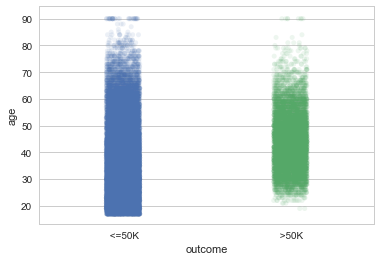

In [4]:
sns.stripplot(x="outcome", y="age", data=data, jitter=True, alpha=.1);

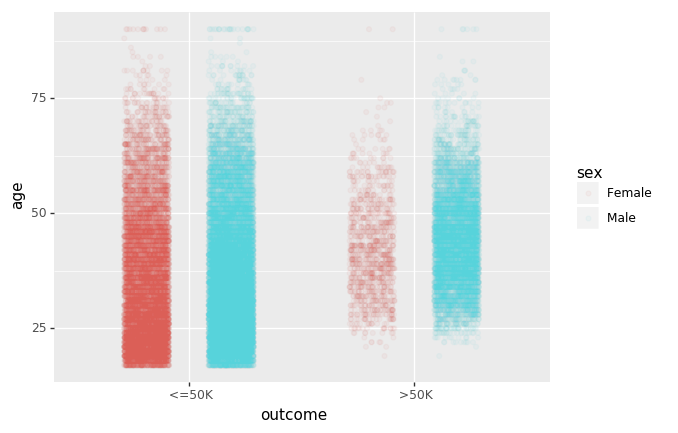

<ggplot: (273398066)>

In [5]:
ggplot(aes(y='age', x='outcome', color='sex'), data=data) +  geom_point(aes(fill = "sex"), position=position_jitterdodge(0.2), alpha=.05)

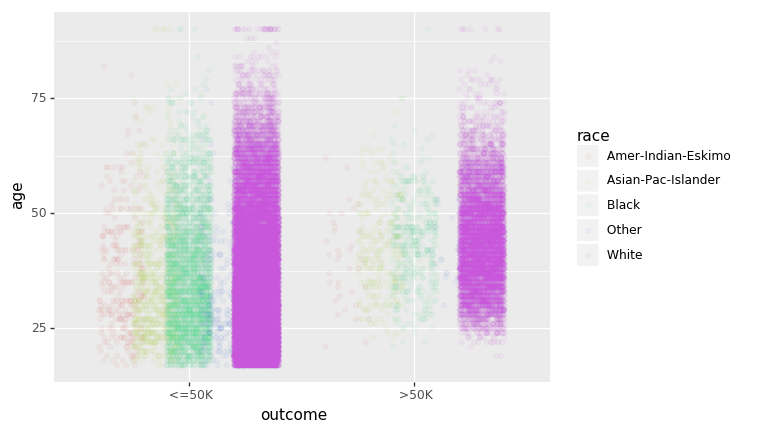

<ggplot: (272914352)>

In [6]:
ggplot(aes(y='age', x='outcome', color='race'), data=data) +  geom_point(aes(fill = "race"), position=position_jitterdodge(0.2), alpha=.05)

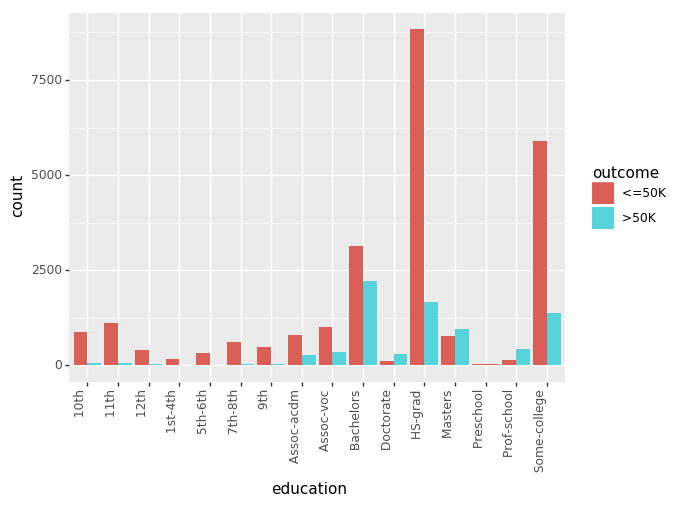

<ggplot: (-9223372036571935032)>

In [7]:
ggplot(aes(x='education', fill = 'outcome'), data=data) + geom_bar(position="dodge") + theme(axis_text_x = element_text(angle = 90, hjust = 1))

In [8]:
N = data.shape[0]
g = pd.crosstab(data.outcome, data.sex)/ pd.crosstab(data.outcome, data.sex).sum()
# makes a series with a multi-index. # turns multi-index into columns
a = pd.DataFrame(g.unstack()).reset_index(inplace=False) 
a.rename(columns = {0:"percent"}, inplace=True)

In [9]:
a

,sex,outcome,percent
0,Female,<=50K,0.890539
1,Female,>50K,0.109461
2,Male,<=50K,0.694263
3,Male,>50K,0.305737


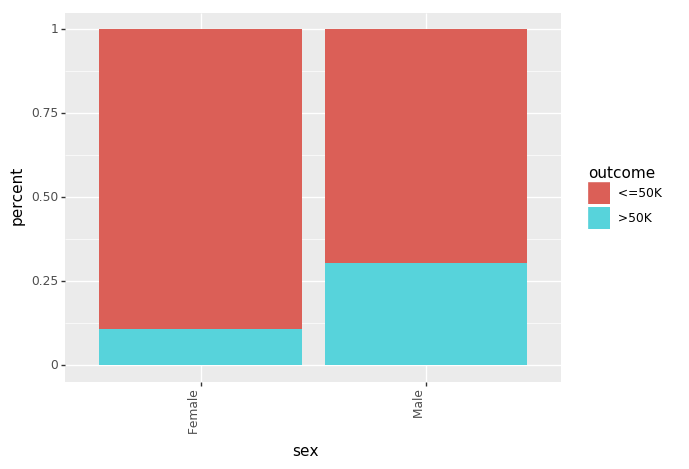

<ggplot: (-9223372036568648851)>

In [10]:
ggplot(aes(x='sex', y='percent', fill = 'outcome'), data=a) + geom_bar(stat="identity") + theme(axis_text_x = element_text(angle = 90, hjust = 1))


In [11]:
var = 'education'
N = data.shape[0]
g = pd.crosstab(data.outcome, data[var])/ pd.crosstab(data.outcome, data[var]).sum()
# makes a series with a multi-index. # turns multi-index into columns
a = pd.DataFrame(g.unstack()).reset_index(inplace=False) 
a.rename(columns = {0:"percent"}, inplace=True)

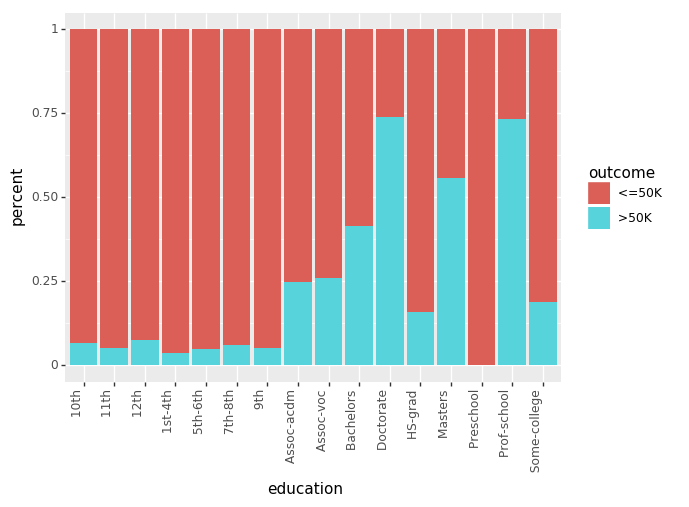

<ggplot: (285162027)>

In [12]:
ggplot(aes(x=var, y='percent', fill = 'outcome'), data=a) + geom_bar(stat="identity") + theme(axis_text_x = element_text(angle = 90, hjust = 1))


In [13]:
pd.crosstab(y, 'outcome') #/N

col_0,outcome
outcome,
<=50K,24720
>50K,7841


In [18]:
# train models and get bias estimations, assumes data are a global variable.
def fit_model(model_type):
    '''
    model_type: sklearn model with fit and predict
    '''
    model = model_type
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("confusion matrix")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=["<=50K",">50K"]))
    return(model)

def get_aequitas(model, thresholds = { "rank_abs": [10, 50, 100],
              "rank_pct": [1.0, 2.0, 5.0, 10.0 ]}, include_df=False):
    '''
    model: fit model from sklearn
    thresholds: dictionary with 'rank_abs' and 'rank_pct' as keys
    '''
    g = Group()
    thresholds = thresholds
    df = output(model)
    tabs = g.get_crosstabs(df, thresholds, 1)
    if include_df:
        return df, tabs
    return tabs


# Logistic Regression

In [15]:
model = fit_model(LogisticRegression())

confusion matrix
[[7161  256]
 [1735  617]]
             precision    recall  f1-score   support

      <=50K       0.80      0.97      0.88      7417
       >50K       0.71      0.26      0.38      2352

avg / total       0.78      0.80      0.76      9769



In [19]:
df, results = get_aequitas(model, include_df=True)

Feature Columns (Groups): ['education' 'gender' 'race']
COUNTS::: education
 10th             292
 11th             341
 12th             116
 1st-4th           45
 5th-6th           79
 7th-8th          183
 9th              151
 Assoc-acdm       303
 Assoc-voc        406
 Bachelors       1632
 Doctorate        125
 HS-grad         3214
 Masters          481
 Preschool         16
 Prof-school      178
 Some-college    2207
Name: entity_id, dtype: int64
COUNTS::: gender
 Female    3199
 Male      6570
Name: entity_id, dtype: int64
COUNTS::: race
 Amer-Indian-Eskimo     100
 Asian-Pac-Islander     303
 Black                  967
 Other                   73
 White                 8326
Name: entity_id, dtype: int64


In [17]:
!pwd

/Users/arianisfeld/Desktop/bias/aequitas-public/src


In [21]:
results

,TPR,group_value,group_variable,k,model_id,parameter,TNR,FOmR,FDR,FPR,...,PPrev,FP,FN,TN,TP,group_label_neg,group_label_pos,group_size,total_entities,Prev
0,0.000000,10th,education,10,1,10_abs,1.000000,0.061644,0.000000,0.000000,...,0.000000,0,18,274,0,274,18,292,9769,0.061644
1,0.055556,10th,education,50,1,50_abs,0.985401,0.059233,0.800000,0.014599,...,0.017123,4,17,270,1,274,18,292,9769,0.061644
2,0.055556,10th,education,100,1,100_abs,0.978102,0.059649,0.857143,0.021898,...,0.023973,6,17,268,1,274,18,292,9769,0.061644
3,1.000000,10th,education,9769,1,1.0_pct,0.000000,0.000000,0.938356,1.000000,...,1.000000,274,0,0,18,274,18,292,9769,0.061644
4,1.000000,10th,education,9769,1,2.0_pct,0.000000,0.000000,0.938356,1.000000,...,1.000000,274,0,0,18,274,18,292,9769,0.061644
5,1.000000,10th,education,9769,1,5.0_pct,0.000000,0.000000,0.938356,1.000000,...,1.000000,274,0,0,18,274,18,292,9769,0.061644
6,1.000000,10th,education,9769,1,10.0_pct,0.000000,0.000000,0.938356,1.000000,...,1.000000,274,0,0,18,274,18,292,9769,0.061644
7,0.000000,11th,education,10,1,10_abs,1.000000,0.043988,0.000000,0.000000,...,0.000000,0,15,326,0,326,15,341,9769,0.043988
8,0.000000,11th,education,50,1,50_abs,0.996933,0.044118,1.000000,0.003067,...,0.002933,1,15,325,0,326,15,341,9769,0.043988
9,0.000000,11th,education,100,1,100_abs,0.993865,0.044248,1.000000,0.006135,...,0.005865,2,15,324,0,326,15,341,9769,0.043988


In [18]:
results.to_csv("../demo/logistic_crosstab.csv")

# Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
model = fit_model(RandomForestClassifier())

confusion matrix
[[6930  487]
 [ 973 1379]]
             precision    recall  f1-score   support

      <=50K       0.88      0.93      0.90      7417
       >50K       0.74      0.59      0.65      2352

avg / total       0.84      0.85      0.84      9769



In [21]:
results = get_aequitas(model)

Feature Columns (Groups): ['education' 'gender' 'race']
COUNTS::: education
 10th             292
 11th             341
 12th             116
 1st-4th           45
 5th-6th           79
 7th-8th          183
 9th              151
 Assoc-acdm       303
 Assoc-voc        406
 Bachelors       1632
 Doctorate        125
 HS-grad         3214
 Masters          481
 Preschool         16
 Prof-school      178
 Some-college    2207
Name: entity_id, dtype: int64
COUNTS::: gender
 Female    3199
 Male      6570
Name: entity_id, dtype: int64
COUNTS::: race
 Amer-Indian-Eskimo     100
 Asian-Pac-Islander     303
 Black                  967
 Other                   73
 White                 8326
Name: entity_id, dtype: int64


In [22]:
results

,TPR,group_value,group_variable,k,model_id,parameter,TNR,FOmR,FDR,FPR,...,PPrev,FP,FN,TN,TP,group_label_neg,group_label_pos,group_size,total_entities,Prev
0,0.000000,10th,education,10,1,10_abs,1.000000,0.061644,0.000000,0.000000,...,0.000000,0,18,274,0,274,18,292,9769,0.061644
1,0.000000,10th,education,50,1,50_abs,1.000000,0.061644,0.000000,0.000000,...,0.000000,0,18,274,0,274,18,292,9769,0.061644
2,0.000000,10th,education,100,1,100_abs,0.992701,0.062069,1.000000,0.007299,...,0.006849,2,18,272,0,274,18,292,9769,0.061644
3,1.000000,10th,education,9769,1,1.0_pct,0.000000,0.000000,0.938356,1.000000,...,1.000000,274,0,0,18,274,18,292,9769,0.061644
4,1.000000,10th,education,9769,1,2.0_pct,0.000000,0.000000,0.938356,1.000000,...,1.000000,274,0,0,18,274,18,292,9769,0.061644
5,1.000000,10th,education,9769,1,5.0_pct,0.000000,0.000000,0.938356,1.000000,...,1.000000,274,0,0,18,274,18,292,9769,0.061644
6,1.000000,10th,education,9769,1,10.0_pct,0.000000,0.000000,0.938356,1.000000,...,1.000000,274,0,0,18,274,18,292,9769,0.061644
7,0.000000,11th,education,10,1,10_abs,1.000000,0.043988,0.000000,0.000000,...,0.000000,0,15,326,0,326,15,341,9769,0.043988
8,0.000000,11th,education,50,1,50_abs,0.990798,0.044379,1.000000,0.009202,...,0.008798,3,15,323,0,326,15,341,9769,0.043988
9,0.000000,11th,education,100,1,100_abs,0.981595,0.044776,1.000000,0.018405,...,0.017595,6,15,320,0,326,15,341,9769,0.043988


In [23]:
results.to_csv("../demo/random_forest_crosstab.csv")

# SVM

In [24]:
model = fit_model(sk.svm.SVC(C=10,probability=True))

confusion matrix
[[7184  233]
 [2170  182]]
             precision    recall  f1-score   support

      <=50K       0.77      0.97      0.86      7417
       >50K       0.44      0.08      0.13      2352

avg / total       0.69      0.75      0.68      9769



In [ ]:
Test counts
Make pictures of results against models.